In [2]:
!pip install pandas yfinance networkx matplotlib pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 3.7 MB/s eta 0:00:00
  Created wheel for pygraphviz: filename=pygraphviz-1.12-cp310-cp310-linux_x86_64.whl size=97503 sha256=1a475721d43e917ad27349b266e92b9e8794e71620e881e9cba58d152a5898b2
  Stored in directory: /root/.cache/pip/wheels/1d/ee/b5/a2f54f9e9b3951599c05dcce270ca85e472f8e6cec470e397a
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=290467 sha256=6ab8eeb518098f474977db45d149777ddb529d9142cf274f5f5456f023f04235


/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and wil

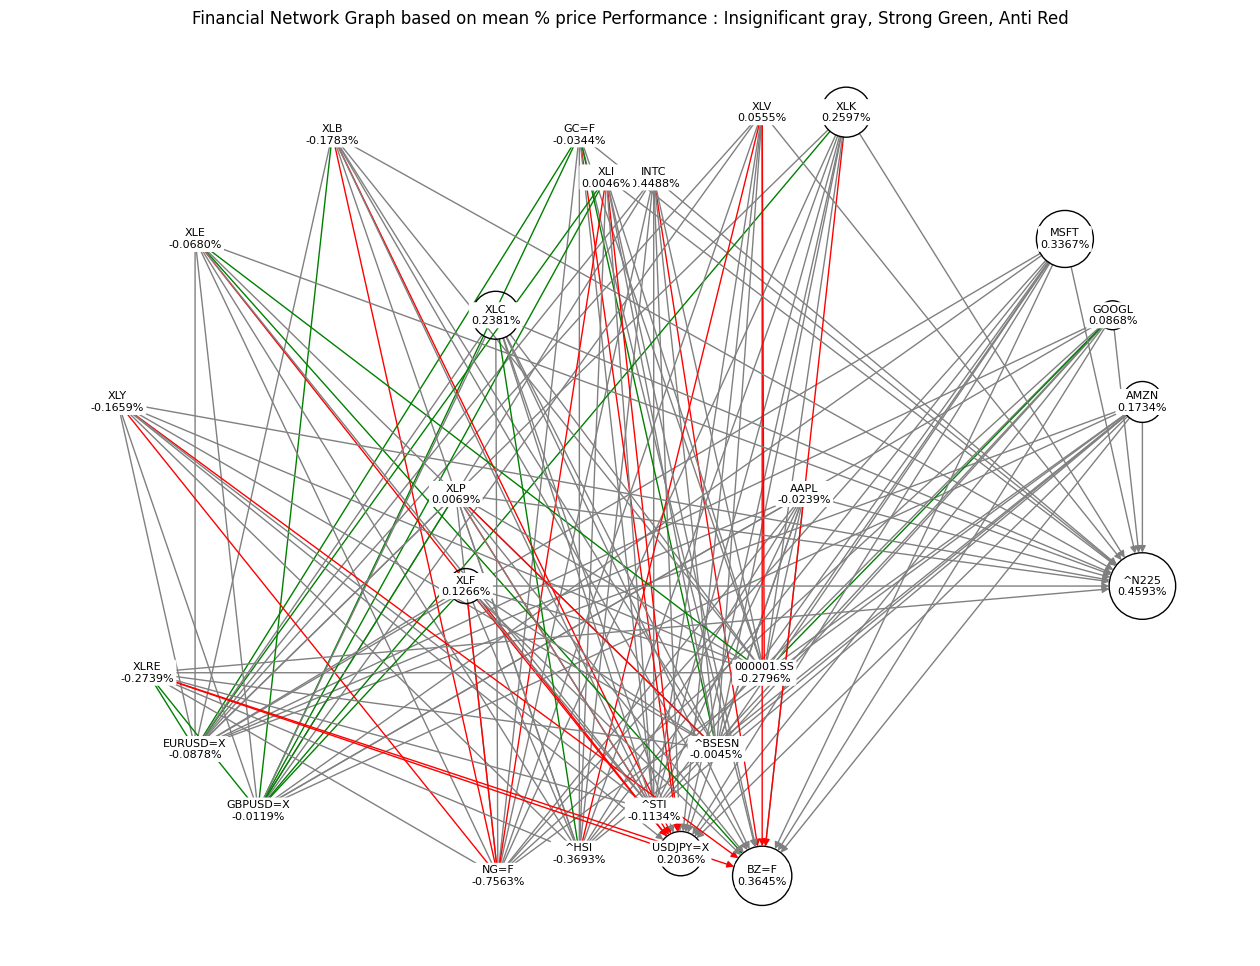

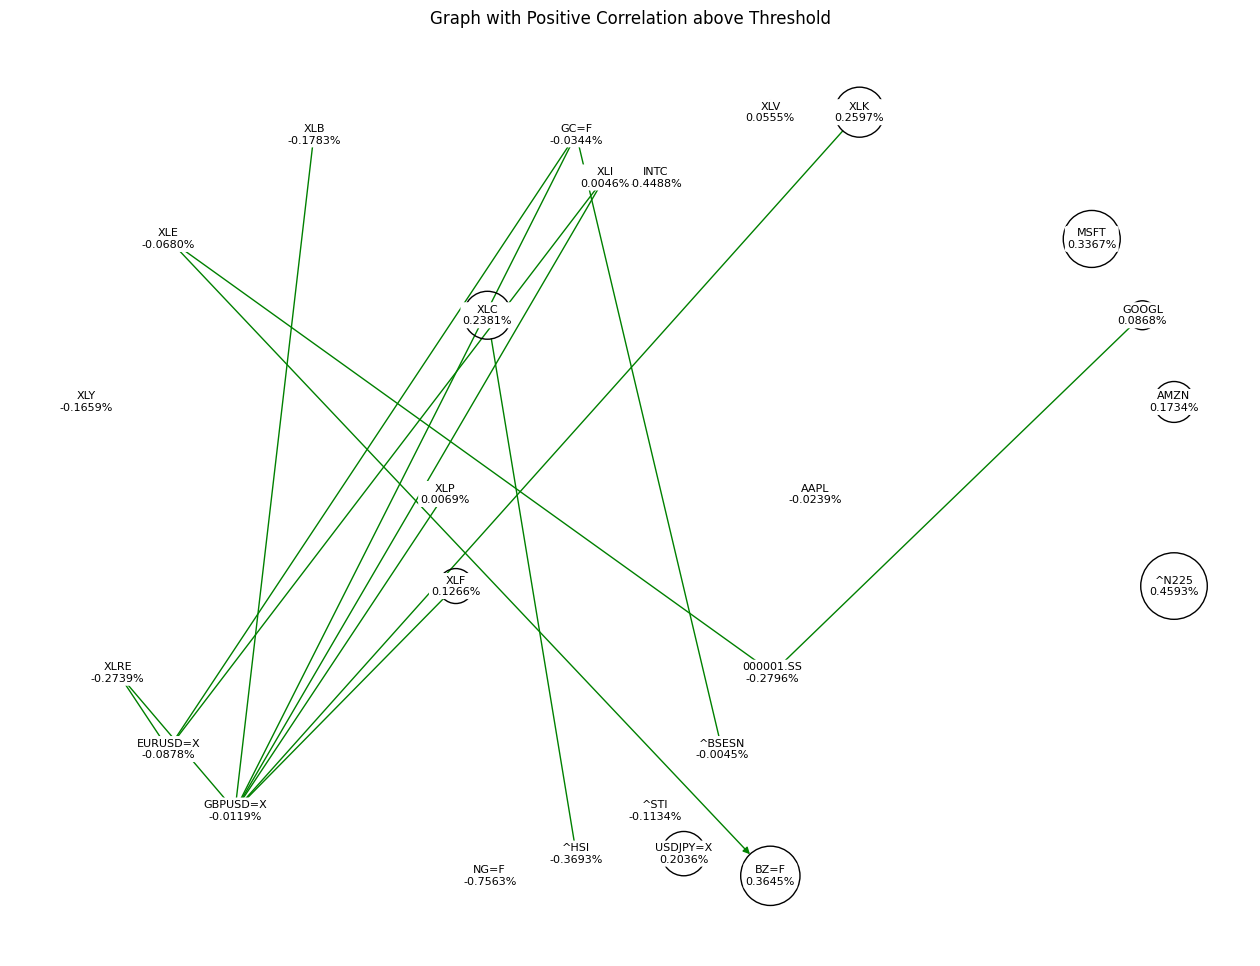

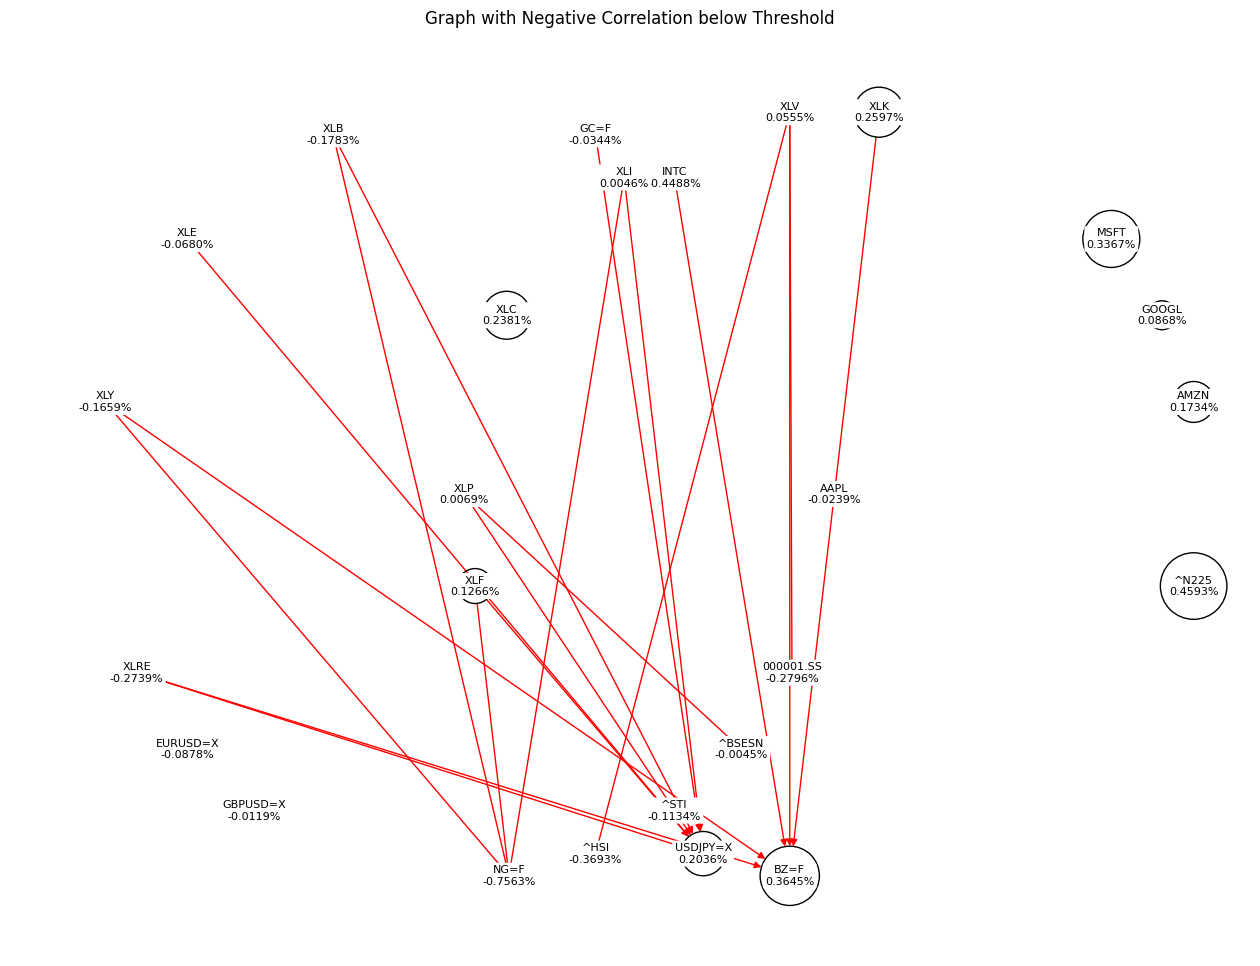

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# Assuming you have already loaded the data and defined stocks and currencies
# List of stock tickers and currencies
stocks = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'INTC', 'GC=F', 'XLK', 'XLV', 'XLB', 'XLI', 'XLE', 'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLRE']
currencies = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'BZ=F', 'NG=F', '^HSI', '^STI', '^BSESN', '000001.SS', '^N225']

# Download historical stock prices and currency exchange rates
data = yf.download(stocks + currencies, start='2024-01-01', end='2024-02-01')['Adj Close']

# Calculate 6-month performance data
performance_data = data.pct_change().mean()

# Calculate correlation data
correlation_data = data.pct_change().corr()

# Set correlation thresholds
positive_threshold = 0.4
negative_threshold = -0.2

# Create a directed graph
G = nx.DiGraph()

# Add nodes for stocks
for stock in stocks:
    size = performance_data.get(stock, 0)
    G.add_node(stock, size=size)

# Add nodes for currencies
for currency in currencies:
    size = performance_data.get(currency, 0)
    G.add_node(currency, size=size)

# Add edges with weights based on correlation strength
for stock in stocks:
    for currency in currencies:
        correlation = correlation_data.loc[stock, currency]
        G.add_edge(stock, currency, weight=correlation)

# Set node positions with a circular layout
pos = nx.circular_layout(G)

# Adjust positions based on node values
for node in G.nodes:
    size = G.nodes[node].get('size', 0)
    if size < 0:
        pos[node] = (pos[node][0] - 1, pos[node][1])

# Create a figure and axis for the main graph
fig, ax_main = plt.subplots(figsize=(16, 12))

# Draw the initial graph with edges based on correlation thresholds
sizes_main = [G.nodes[node].get('size', 0) * 500000 for node in G.nodes]
edge_colors_main = ['red' if G.edges[edge]['weight'] < negative_threshold else 'green' if G.edges[edge]['weight'] > positive_threshold else 'gray' for edge in G.edges]
nx.draw(G, pos, ax=ax_main, with_labels=False, font_size=8, node_size=sizes_main, font_color='black',
        edge_color=edge_colors_main, arrowsize=10, node_color='none', edgecolors='black')

# Draw nodes with text in front
labels_main = {n: f"{n}\n{performance_data.get(n, 0):.4%}" for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels_main, font_color='black', font_size=8,
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Financial Network Graph based on mean % price Performance : Insignificant gray, Strong Green, Anti Red")

# Create a figure and axes for green edges
fig_green, ax_green = plt.subplots(figsize=(16, 12))

# Filter edges for positive correlation above the threshold
green_edges = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] > positive_threshold]

# Draw the graph with green edges
nx.draw(G, pos, ax=ax_green, with_labels=False, font_size=8, node_size=sizes_main, font_color='black',
        edgelist=green_edges, edge_color='green', arrowsize=10, node_color='none', edgecolors='black')

# Draw nodes with text in front
labels_green = {n: f"{n}\n{performance_data.get(n, 0):.4%}" for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels_green, font_color='black', font_size=8,
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Graph with Positive Correlation above Threshold")

# Create a figure and axes for red edges
fig_red, ax_red = plt.subplots(figsize=(16, 12))

# Filter edges for negative correlation below the threshold
red_edges = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] < negative_threshold]

# Draw the graph with red edges
nx.draw(G, pos, ax=ax_red, with_labels=False, font_size=8, node_size=sizes_main, font_color='black',
        edgelist=red_edges, edge_color='red', arrowsize=10, node_color='none', edgecolors='black')

# Draw nodes with text in front
labels_red = {n: f"{n}\n{performance_data.get(n, 0):.4%}" for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels_red, font_color='black', font_size=8,
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Graph with Negative Correlation below Threshold")

plt.show()

/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 co

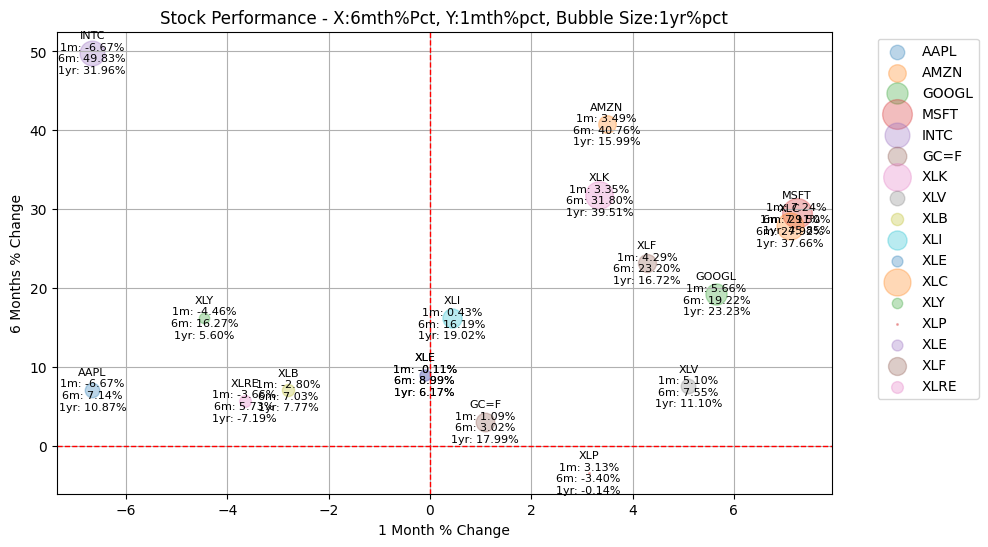

In [4]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

# Function to get historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to calculate percentage change over a given period
def calculate_percentage_change(data, period):
    return data['Adj Close'].pct_change(periods=period) * 100

# List of stocks to analyze
#stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

# Set the start and end dates for the analysis
start_date = '2022-01-01'
end_date = '2024-02-01'

# Create a DataFrame to store the percentage changes
percentage_changes = pd.DataFrame()

# Get and calculate percentage changes for each stock
for stock in stocks:
    stock_data = get_stock_data(stock, start_date, end_date)
    
    # Add debug statement to check the last rows of the stock data
    #print(f"{stock} - Last rows of stock data:\n{stock_data.tail()}")

    percentage_changes[f'{stock}_1mth'] = calculate_percentage_change(stock_data, 30)  # approximately 21 trading days in a month
    percentage_changes[f'{stock}_6mth'] = calculate_percentage_change(stock_data, 180)  # approximately 126 trading days in 6 months
    percentage_changes[f'{stock}_1yr'] = calculate_percentage_change(stock_data, 360)  # approximately 252 trading days in 1 year


# Plotting the bubble chart
plt.figure(figsize=(10, 6))

# Lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through each stock
for stock in stocks:
    # Extract percentage changes for 1-month, 6-month, and 1-year
    pct_change_1mth = percentage_changes[f'{stock}_1mth'].dropna().iloc[-1]
    pct_change_6mth = percentage_changes[f'{stock}_6mth'].dropna().iloc[-1]
    pct_change_1yr = percentage_changes[f'{stock}_1yr'].dropna().iloc[-1]

    # Calculate bubble size based on 1-year percentage change
    bubble_size = abs(pct_change_1yr) * 10  # You can adjust the multiplier for better visualization

    # Plot the bubble with varying size and transparency
    scatter = plt.scatter(pct_change_1mth, pct_change_6mth, label=stock, s=bubble_size, alpha=0.3)

    # Add label for the bubble with stock name and values
    plt.text(pct_change_1mth, pct_change_6mth, f"{stock}\n1m: {pct_change_1mth:.2f}%\n6m: {pct_change_6mth:.2f}%\n1yr: {pct_change_1yr:.2f}%", ha='center', va='center', fontsize=8)

    # Add debug statement
    #print(f"{stock} - 1 Month: {pct_change_1mth:.2f}%, 6 Months: {pct_change_6mth:.2f}%, 1 Year: {pct_change_1yr:.2f}%")

    # Append scatter plot to legend handles and labels
    legend_handles.append(scatter)
    legend_labels.append(stock)

# Add labels and gridlines
plt.title('Stock Performance - X:6mth%Pct, Y:1mth%pct, Bubble Size:1yr%pct')
plt.xlabel('1 Month % Change')
plt.ylabel('6 Months % Change')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal red line at y=0
plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Add vertical red line at x=0
plt.grid(True)

# Create custom legend with markers of fixed size
plt.legend(legend_handles, legend_labels, handler_map={plt.Line2D: HandlerPathCollection()}, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 co

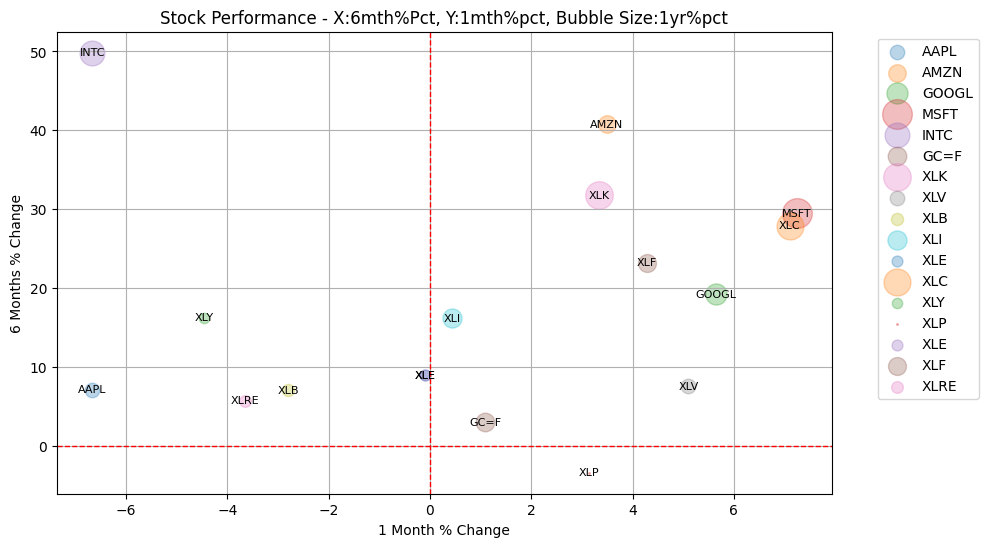

In [9]:
# code to scatter plot 1m, 6m, 12m

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

# Function to get historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to calculate percentage change over a given period
def calculate_percentage_change(data, period):
    return data['Adj Close'].pct_change(periods=period) * 100

# List of stocks to analyze
#stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

# Set the start and end dates for the analysis
start_date = '2022-01-01'
end_date = '2024-02-01'

# Create a DataFrame to store the percentage changes
percentage_changes = pd.DataFrame()

# Get and calculate percentage changes for each stock
for stock in stocks:
    stock_data = get_stock_data(stock, start_date, end_date)
    
    # Add debug statement to check the last rows of the stock data
    #print(f"{stock} - Last rows of stock data:\n{stock_data.tail()}")

    percentage_changes[f'{stock}_1mth'] = calculate_percentage_change(stock_data, 30)  # approximately 21 trading days in a month
    percentage_changes[f'{stock}_6mth'] = calculate_percentage_change(stock_data, 180)  # approximately 126 trading days in 6 months
    percentage_changes[f'{stock}_1yr'] = calculate_percentage_change(stock_data, 360)  # approximately 252 trading days in 1 year


# Plotting the bubble chart
plt.figure(figsize=(10, 6))

# Lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Selectively show labels and the %pct 1m 6m 1yr for these stocks
#selected_stocks = ['AAPL', 'GOOGL', 'TSLA']
selected_stocks = ['']

# Iterate through each stock
for stock in stocks:
    # Extract percentage changes for 1-month, 6-month, and 1-year
    pct_change_1mth = percentage_changes[f'{stock}_1mth'].dropna().iloc[-1]
    pct_change_6mth = percentage_changes[f'{stock}_6mth'].dropna().iloc[-1]
    pct_change_1yr = percentage_changes[f'{stock}_1yr'].dropna().iloc[-1]

    # Calculate bubble size based on 1-year percentage change
    bubble_size = abs(pct_change_1yr) * 10  # You can adjust the multiplier for better visualization

    # Plot the bubble with varying size and transparency
    scatter = plt.scatter(pct_change_1mth, pct_change_6mth, label=stock, s=bubble_size, alpha=0.3)

    # Add label for the bubble with stock name and values only for selected stocks
    if stock in selected_stocks:
        plt.text(pct_change_1mth, pct_change_6mth, f"{stock}\n1m: {pct_change_1mth:.2f}%\n6m: {pct_change_6mth:.2f}%\n1yr: {pct_change_1yr:.2f}%", ha='center', va='center', fontsize=8)
    else:
        plt.text(pct_change_1mth, pct_change_6mth, f"{stock}", ha='center', va='center', fontsize=8)

    # Append scatter plot to legend handles and labels
    legend_handles.append(scatter)
    legend_labels.append(stock)

# Add labels and gridlines
plt.title('Stock Performance - X:6mth%Pct, Y:1mth%pct, Bubble Size:1yr%pct')
plt.xlabel('1 Month % Change')
plt.ylabel('6 Months % Change')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal red line at y=0
plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Add vertical red line at x=0
plt.grid(True)

# Create custom legend with markers of fixed size
plt.legend(legend_handles, legend_labels, handler_map={plt.Line2D: HandlerPathCollection()}, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 co

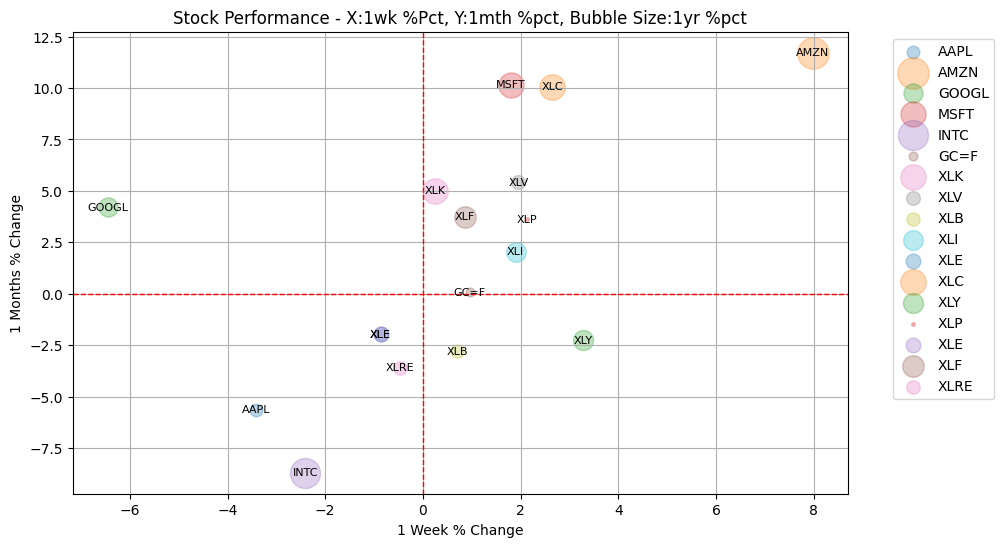

In [17]:
# code to scatter plot 1w, 1m, 6m

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

# Function to get historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to calculate percentage change over a given period
def calculate_percentage_change(data, period):
    return data['Adj Close'].pct_change(periods=period) * 100

# List of stocks to analyze
#stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

# Set the start and end dates for the analysis
start_date = '2022-01-01'
end_date = '2024-02-05'

# Create a DataFrame to store the percentage changes
percentage_changes = pd.DataFrame()

# Get and calculate percentage changes for each stock
for stock in stocks:
    stock_data = get_stock_data(stock, start_date, end_date)
    
    # Add debug statement to check the last rows of the stock data
    #print(f"{stock} - Last rows of stock data:\n{stock_data.tail()}")

    percentage_changes[f'{stock}_1wk'] = calculate_percentage_change(stock_data, 5)  # approximately 21 trading days in a month
    percentage_changes[f'{stock}_1mth'] = calculate_percentage_change(stock_data, 30)  # approximately 126 trading days in 6 months
    percentage_changes[f'{stock}_1yr'] = calculate_percentage_change(stock_data, 180)  # approximately 252 trading days in 1 year


# Plotting the bubble chart
plt.figure(figsize=(10, 6))

# Lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Selectively show labels and the %pct 1m 6m 1yr for these stocks
#selected_stocks = ['AAPL', 'GOOGL', 'TSLA']
selected_stocks = ['']

# Iterate through each stock
for stock in stocks:
    # Extract percentage changes for 1-month, 6-month, and 1-year
    pct_change_1wk = percentage_changes[f'{stock}_1wk'].dropna().iloc[-1]
    pct_change_1mth = percentage_changes[f'{stock}_1mth'].dropna().iloc[-1]
    pct_change_1yr = percentage_changes[f'{stock}_1yr'].dropna().iloc[-1]

    # Calculate bubble size based on 1-year percentage change
    bubble_size = abs(pct_change_1yr) * 10  # You can adjust the multiplier for better visualization

    # Plot the bubble with varying size and transparency
    scatter = plt.scatter(pct_change_1wk, pct_change_1mth, label=stock, s=bubble_size, alpha=0.3)

    # Add label for the bubble with stock name and values only for selected stocks
    if stock in selected_stocks:
        plt.text(pct_change_1wk, pct_change_1mth, f"{stock}\n1m: {pct_change_1wk:.2f}%\n6m: {pct_change_1mth:.2f}%\n1yr: {pct_change_1yr:.2f}%", ha='center', va='center', fontsize=8)
    else:
        plt.text(pct_change_1wk, pct_change_1mth, f"{stock}", ha='center', va='center', fontsize=8)

    # Append scatter plot to legend handles and labels
    legend_handles.append(scatter)
    legend_labels.append(stock)

# Add labels and gridlines
plt.title('Stock Performance - X:1wk %Pct, Y:1mth %pct, Bubble Size:1yr %pct')
plt.xlabel('1 Week % Change')
plt.ylabel('1 Months % Change')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal red line at y=0
plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Add vertical red line at x=0
plt.grid(True)

# Create custom legend with markers of fixed size
plt.legend(legend_handles, legend_labels, handler_map={plt.Line2D: HandlerPathCollection()}, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()